<a href="https://colab.research.google.com/github/AmirGhnbr/Bit_pred/blob/dev_branch/bit_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
TICKER = 'BTC-USD'

In [4]:
import yfinance as yf
import datetime
import pandas as pd

today = datetime.datetime.now()
start_year_ago = today-datetime.timedelta(days = 720)
btc_data = yf.download(tickers=TICKER, interval="1h",start= start_year_ago, end=today)
btc_data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-03-29 11:00:00+00:00,28380.179688,28380.375000,28278.326172,28360.330078,28360.330078,25284608
2023-03-29 12:00:00+00:00,28356.123047,28435.039062,28262.417969,28435.039062,28435.039062,204386304
2023-03-29 13:00:00+00:00,28455.462891,28476.214844,28343.751953,28404.966797,28404.966797,391882752
2023-03-29 14:00:00+00:00,28403.763672,28572.785156,28282.330078,28285.476562,28285.476562,294770688
2023-03-29 15:00:00+00:00,28291.001953,28344.910156,28280.646484,28344.910156,28344.910156,19204096


In [5]:
btc_data["OHLC4"] = (btc_data["Open"] + btc_data["High"] + btc_data["Low"] + btc_data["Close"]) / 4 
btc_data.tail()

,Open,High,Low,Close,Adj Close,Volume,OHLC4
Datetime,,,,,,,
2023-03-29 11:00:00+00:00,28380.179688,28380.375000,28278.326172,28360.330078,28360.330078,25284608,28349.802734
2023-03-29 12:00:00+00:00,28356.123047,28435.039062,28262.417969,28435.039062,28435.039062,204386304,28372.154785
2023-03-29 13:00:00+00:00,28455.462891,28476.214844,28343.751953,28404.966797,28404.966797,391882752,28420.099121
2023-03-29 14:00:00+00:00,28403.763672,28572.785156,28282.330078,28285.476562,28285.476562,294770688,28386.088867
2023-03-29 15:00:00+00:00,28291.001953,28344.910156,28280.646484,28344.910156,28344.910156,19204096,28315.367188


In [6]:
bitcoin_prices_ohlc4_df = pd.DataFrame(btc_data["OHLC4"]).rename(columns={"OHLC4": "Price"})
bitcoin_prices_ohlc4_df.tail()

,Price
Datetime,
2023-03-29 11:00:00+00:00,28349.802734
2023-03-29 12:00:00+00:00,28372.154785
2023-03-29 13:00:00+00:00,28420.099121
2023-03-29 14:00:00+00:00,28386.088867
2023-03-29 15:00:00+00:00,28315.367188


In [7]:
def timesteps_and_prices(df):
  '''
  Parameters:
      df: dataframe that contains two columns (Date column, price column)
  output:
      timesteps : in pandas datetime format
      prices: in numpy format
  '''
  timesteps = pd.to_datetime(df.index.to_numpy())
  prices = df["Price"].to_numpy()

  return timesteps, prices


In [8]:
timesteps, prices = timesteps_and_prices(bitcoin_prices_ohlc4_df)
timesteps[:10], prices[:10]

(DatetimeIndex(['2021-04-08 15:00:00+00:00', '2021-04-08 16:00:00+00:00',
                '2021-04-08 17:00:00+00:00', '2021-04-08 18:00:00+00:00',
                '2021-04-08 19:00:00+00:00', '2021-04-08 20:00:00+00:00',
                '2021-04-08 21:00:00+00:00', '2021-04-08 22:00:00+00:00',
                '2021-04-09 00:00:00+00:00', '2021-04-09 01:00:00+00:00'],
               dtype='datetime64[ns, UTC]', freq=None),
 array([57813.51367188, 57856.62695312, 57812.89648438, 57955.01757812,
        58043.94042969, 57863.69140625, 57878.50292969, 57966.66894531,
        58339.05664062, 58292.22753906]))

## Scale the data

In [27]:
import numpy as np
import tensorflow as tf

In [42]:
from sklearn.preprocessing import RobustScaler

def scale_data(prices):
  scaler = RobustScaler()
  scaled_prices= scaler.fit_transform(prices.reshape(-1, 1))
  scaled_prices= scaled_prices.reshape(1,-1)
  return scaled_prices.squeeze()
prices, scale_data(prices)

(array([57813.51367188, 57856.62695312, 57812.89648438, ...,
        28420.09912109, 28386.08886719, 28315.3671875 ]),
 array([ 0.97737379,  0.97917824,  0.97734796, ..., -0.25284807,
        -0.25427153, -0.25723149]))

## Split the data

In [9]:
def get_train_test_split(timesteps,prices, train_test_ratio=0.8):
  '''
  Parameters: 
      timesteps
      prices
  output:
      X_train, y_train, X_test, y_test
  '''
  split_size = int(0.8 * len(prices))
  X_train, y_train = timesteps[:split_size], prices[:split_size]

  X_test, y_test = timesteps[split_size:], prices[split_size:]
  return X_train, y_train, X_test, y_test


In [44]:
timesteps, prices = timesteps_and_prices(bitcoin_prices_ohlc4_df)
scaled_prices = scale_data(prices)
X_train, y_train, X_test, y_test = get_train_test_split(timesteps,scaled_prices)
X_train[:10], y_train[:10]

(DatetimeIndex(['2021-04-08 15:00:00+00:00', '2021-04-08 16:00:00+00:00',
                '2021-04-08 17:00:00+00:00', '2021-04-08 18:00:00+00:00',
                '2021-04-08 19:00:00+00:00', '2021-04-08 20:00:00+00:00',
                '2021-04-08 21:00:00+00:00', '2021-04-08 22:00:00+00:00',
                '2021-04-09 00:00:00+00:00', '2021-04-09 01:00:00+00:00'],
               dtype='datetime64[ns, UTC]', freq=None),
 array([0.97737379, 0.97917824, 0.97734796, 0.98329625, 0.98701799,
        0.97947391, 0.98009383, 0.9837839 , 0.99936969, 0.99740972]))

In [45]:

import matplotlib.pyplot as plt 

def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters:
      timesteps : array of timesteps
      values : array of values across time
      format : style of plot, default "."
      start : where to start the plot (setting a value will index from start of timesteps & values)
      end : where to end the plot (setting a value will index from end of timesteps & values)
      label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

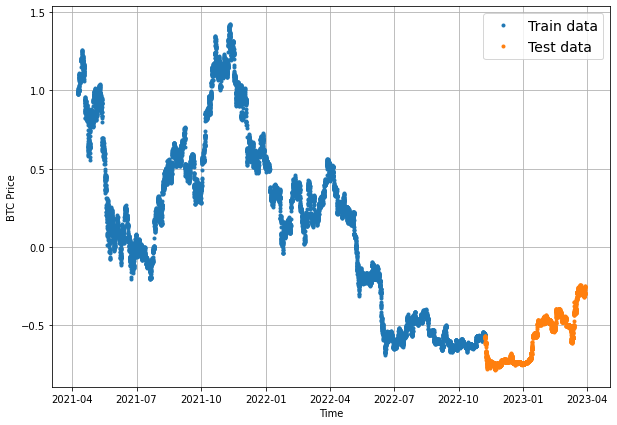

In [46]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Define evaluation metrics

In [28]:
def smape(actual, forecast):
    """
    Calculates Symmetric Mean Absolute Percentage Error (SMAPE) for time series evaluation
    Parameters:
        targets: a numpy array of actual values
        predictions: a numpy array of predicted values
    Returns:
        smape: the SMAPE value
    """
    epsilon = 1e-8
    dividend = tf.abs(actual - forecast)
    denominator = tf.abs(actual) + tf.abs(forecast)
    smape = 200 * tf.reduce_sum(tf.divide(dividend, denominator + epsilon))/tf.size(actual,out_type=tf.float32)
    return smape

In [29]:
def mape(actual, forecast):
    """
    Calculates Symmetric Mean Absolute Percentage Error (SMAPE) for time series evaluation
    Parameters:
        targets: a numpy array of actual values
        predictions: a numpy array of predicted values
    Returns:
        mape: the SMAPE value
    """
    epsilon = 1e-8
    dividend = tf.abs(actual-forecast)
    denomenator = tf.abs(actual)
    mape = 100*tf.reduce_sum(tf.divide(dividend,denomenator + epsilon))/tf.size(actual,out_type=tf.float32)
    return mape

In [30]:
def mean_absolute_scaled_error(actual, forecast, horizon=1):
    """
    Parameters:
        actual: numpy array-like with actual values
        forecast: numpy array-like with forecasted values
        horizon: int for the difference between naive forecast and actual value
    Outputs:
        mase: float, mean absolute scaled error
    """
    abs_errors = tf.abs(actual - forecast)

    # Calculate the mean absolute error
    mean_absolute_error = tf.reduce_mean(abs_errors)

    # Calculate the mean absolute error for the naive forecast
    naive_forecast_errors = tf.abs(actual[horizon:] - actual[:-horizon])
    mean_absolute_naive_error = tf.reduce_mean(naive_forecast_errors)

    # Calculate the mean absolute scaled error
    mase = mean_absolute_error / mean_absolute_naive_error

    return mase

In [31]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = mape(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  smape = smape(y_true, y_pred)
  
  if mae.ndim > 0: 
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy(),
          'smape': smape.numpy()}

## Define custom SMAPE metric

In [16]:
import tensorflow as tf 
class SMAPE(tf.keras.metrics.Metric): 
  def __init__(self, name='smape', **kwargs):
     super(SMAPE, self).__init__(name=name, **kwargs) 
     self.epsilon = 1e-8 
     self.total_smape = self.add_weight(name='total', initializer='zeros') 
     self.counter = self.add_weight(name='counter', initializer='zeros') 
  def update_state(self, y_true, y_pred, sample_weight=None): 
    dividend = tf.abs(y_true - y_pred) 
    denominator = tf.abs(y_true) + tf.abs(y_pred) 
    smape = 200 * tf.divide(dividend, denominator + self.epsilon) 
    self.total_smape.assign_add(tf.reduce_sum(smape)) 
    self.counter.assign_add(tf.cast(tf.size(y_true), dtype=tf.float32)) 
  def result(self): 
    return tf.math.divide_no_nan(self.total_smape, self.counter) 
  def reset_states(self): 
    self.total_smape.assign(0.) 
    self.counter.assign(0.) 

## Window the data

In [21]:
HORIZON = 24
WINDOW_SIZE= 4*HORIZON

In [22]:
def get_labelled_windows(x , horizon=1):
  """
  Create labels for windowed dataset
  """
  return x[:,:-horizon] , x[:,-horizon:]

In [23]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [24]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(16943, 16943)

In [25]:
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [26]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(13554, 3389, 13554, 3389)